<a href="https://colab.research.google.com/github/IshanKapadia-Data/Instacart-Market-Basket-Analysis/blob/main/Market_Basket_Analysis_ANN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')




Mounted at /content/drive


In [ ]:
import pandas as pd

df = pd.read_pickle('/content/drive/MyDrive/Finaldata.pkl')
df.head()

,user_id,product_id,total_product_orders_by_user,total_product_reorders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,...,total_reorders_by_user,reorder_propotion_by_user,average_order_size,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1
0,1,196,10.0,9.0,0.900000,1.400000,17.600000,10.0,1.0,1.0,...,41,0.694915,5.9,0.705833,6.0,6.0,9.0,0.666667,1.0,0.666667
1,1,10258,9.0,8.0,0.888889,3.333333,19.555556,10.0,1.0,1.0,...,41,0.694915,5.9,0.705833,6.0,6.0,9.0,0.666667,1.0,0.666667
2,1,10326,1.0,0.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,...,41,0.694915,5.9,0.705833,6.0,6.0,9.0,0.666667,1.0,0.666667
3,1,12427,10.0,9.0,0.900000,3.300000,17.600000,10.0,1.0,1.0,...,41,0.694915,5.9,0.705833,6.0,6.0,9.0,0.666667,1.0,0.666667
4,1,13032,3.0,2.0,0.666667,6.333333,21.666667,10.0,1.0,0.0,...,41,0.694915,5.9,0.705833,6.0,6.0,9.0,0.666667,1.0,0.666667


In [ ]:
def reduce_memory(df):


    start_mem_usg = df.memory_usage().sum() / 1024**2
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")

    for col in df.columns:
        if df[col].dtypes in ["int64", "int32", "int16"]:

            cmin = df[col].min()
            cmax = df[col].max()

            if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)

            elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)

            elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)

        if df[col].dtypes in ["float64", "float32"]:

            cmin = df[col].min()
            cmax = df[col].max()

            if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)

            elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)

    print("")
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")

    return df

In [ ]:
df = reduce_memory(df)

Memory usage of properties dataframe is : 4461.300853729248  MB

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  1204.228039741516  MB
This is  26.99275568324179 % of the initial size


In [ ]:
df['order_diff'] = df.order_number - df.last_ordered_in
df.drop(['user_id', 'product_id'], axis = 1, inplace = True)

In [ ]:
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,total_product_orders_by_user,total_product_reorders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,is_reorder_1,order_number,...,reorder_propotion_by_user,average_order_size,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1,order_diff
0,10.0,9.0,0.899902,1.400391,17.593750,10.0,1.0,1.0,1.0,11.0,...,0.694824,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,1.0
1,9.0,8.0,0.888672,3.333984,19.562500,10.0,1.0,1.0,1.0,11.0,...,0.694824,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,1.0
2,1.0,0.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,0.0,11.0,...,0.694824,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,6.0
3,10.0,9.0,0.899902,3.300781,17.593750,10.0,1.0,1.0,1.0,11.0,...,0.694824,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,1.0
4,3.0,2.0,0.666504,6.332031,21.671875,10.0,1.0,0.0,0.0,11.0,...,0.694824,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,1.0


In [ ]:
df.shape

(8474661, 68)

In [ ]:
label = 'reordered'
x_cols = df.columns.drop('reordered')

In [ ]:
X = df[x_cols]
y = df[label]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.25)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6355995, 67) (6355995,)
(2118666, 67) (2118666,)


In [ ]:
y_train.value_counts()

,count
reordered,
0.0,5734377
1.0,621618


In [ ]:
np.ceil(y_train.value_counts()[0]/y_train.value_counts()[1])

np.float64(10.0)

In [ ]:
y_test.value_counts()

,count
reordered,
0.0,1911460
1.0,207206


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import History
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler

In [ ]:
sc = MinMaxScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [ ]:
input_dim =  X_train_sc.shape[1]
input_dim

67

In [ ]:
y_train = y_train.astype('float32')


In [ ]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def precision_m(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.callbacks import History

# Initialize history callback
history = History()

# Define the model
classifier = Sequential()

# Preferred way: using Input layer for the first layer
classifier.add(Input(shape=(input_dim,)))
classifier.add(Dense(units=64, activation='relu'))
classifier.add(Dense(units=15, activation='relu'))
classifier.add(Dense(units=4, activation='relu'))
classifier.add(Dense(units=1, activation='sigmoid'))

# Compile the model
classifier.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', f1_m, precision_m, recall_m]
)

# Model summary
classifier.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 64)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 15)             │           975 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 4)              │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,396 (21.08 KB)

 Trainable params: 5,396 (21.08 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
%%time

# Fit the model with class weighting and early stopping
classifier.fit(
    X_train_sc,
    y_train,
    epochs=31,
    batch_size=512,
    validation_split=0.10,
    verbose=1,
    class_weight={0: 1, 1: 10},
    callbacks=[
        history,
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0,
            patience=10,
            verbose=1,
            mode='auto',
            restore_best_weights=True
        )
    ]
)


Epoch 1/31
11173/11173 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - accuracy: 0.7230 - f1_m: 0.3541 - loss: 0.9823 - precision_m: 0.2347 - recall_m: 0.7537 - val_accuracy: 0.7707 - val_f1_m: 0.3811 - val_loss: 0.4791 - val_precision_m: 0.2600 - val_recall_m: 0.7228
Epoch 2/31
11173/11173 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.7328 - f1_m: 0.3603 - loss: 0.9553 - precision_m: 0.2367 - recall_m: 0.7702 - val_accuracy: 0.7146 - val_f1_m: 0.3513 - val_loss: 0.5500 - val_precision_m: 0.2268 - val_recall_m: 0.7907
Epoch 3/31
11173/11173 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.7355 - f1_m: 0.3626 - loss: 0.9512 - precision_m: 0.2384 - recall_m: 0.7709 - val_accuracy: 0.7364 - val_f1_m: 0.3636 - val_loss: 0.5224 - val_precision_m: 0.2390 - val_recall_m: 0.7703
Epoch 4/31
11173/11173 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.7351 - f1_m: 0.3624 - loss: 0.9503 - precision_m: 0.2381 - recall_m: 0.7717 - val_accuracy: 0.7297 - val_f1_m: 0.3602 - val_loss: 0.5360 - val_precision_m: 0.

In [ ]:
eval_model=classifier.evaluate(X_train_sc, y_train)
print('loss: ', eval_model[0], 'and Accuracy: ', eval_model[1])

198625/198625 ━━━━━━━━━━━━━━━━━━━━ 430s 2ms/step - accuracy: 0.7709 - f1_m: 0.3598 - loss: 0.4792 - precision_m: 0.2586 - recall_m: 0.6961
loss:  0.47890758514404297 and Accuracy:  0.770954966545105


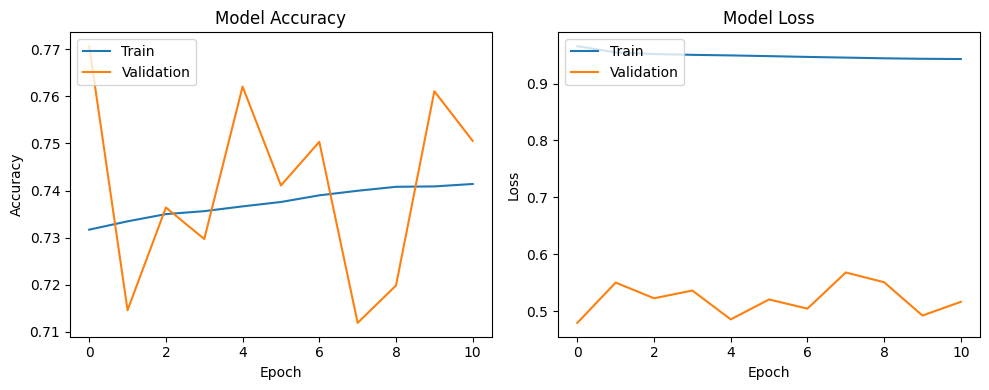

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')
ax[0].set_title('Model Accuracy')

# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')
ax[1].set_title('Model Loss')

plt.tight_layout()
plt.show()


In [ ]:
# Get predicted probabilities
probabilities = classifier.predict(X_test_sc)

# Convert probabilities to class predictions using threshold = 0.5
predictions = (probabilities > 0.5).astype(int)




66209/66209 ━━━━━━━━━━━━━━━━━━━━ 77s 1ms/step



Classification report:
               precision    recall  f1-score   support

         0.0       0.96      0.78      0.86   1911460
         1.0       0.26      0.72      0.38    207206

    accuracy                           0.77   2118666
   macro avg       0.61      0.75      0.62   2118666
weighted avg       0.89      0.77      0.81   2118666

Accuracy Score:  0.7704607521902933
F1 Score:  0.380506048867358
Area under curve:  0.828294599283675 



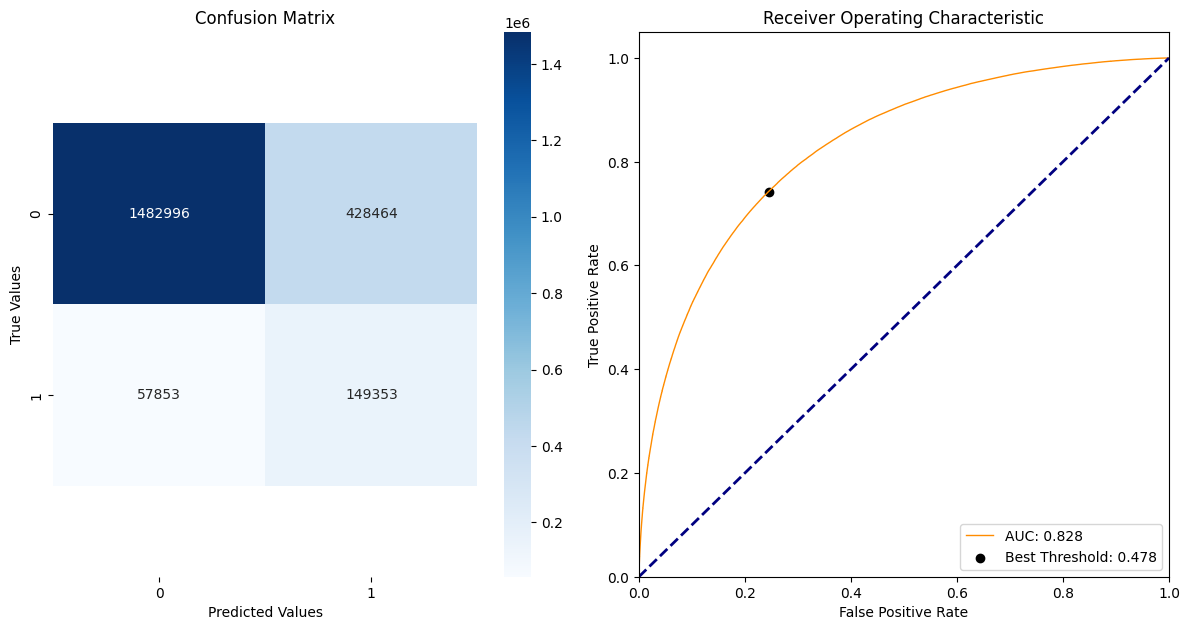

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("\nClassification report:\n", classification_report(y_test, predictions))
print("Accuracy Score: ", accuracy_score(y_test, predictions))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(12, 12))

plt.subplot(221)
sns.heatmap(conf_matrix, fmt="d", annot=True, cmap='Blues')
b, t = plt.ylim()
plt.ylim(b + 0.5, t - 0.5)
plt.title('Confusion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')

# F1 score
f1 = f1_score(y_test, predictions)
print("F1 Score: ", f1)

# ROC AUC
model_roc_auc = roc_auc_score(y_test, probabilities)
print("Area under curve: ", model_roc_auc, "\n")

fpr, tpr, thresholds = roc_curve(y_test, probabilities)
gmeans = np.sqrt(tpr * (1 - fpr))
ix = np.argmax(gmeans)
threshold = np.round(thresholds[ix], 3)

plt.subplot(222)
plt.plot(fpr, tpr, color='darkorange', lw=1, label="AUC: %.3f" % model_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold: ' + str(threshold))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()
